In [105]:
import torch, time
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [32]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    device = torch.device("cuda")
    print("GPU Device:", device)
    print("Device Name:", device_name)

GPU Device: cuda
Device Name: Tesla T4


In [33]:
df = pd.read_csv("/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv",parse_dates=True,index_col='Date and Hour',usecols=['Date and Hour','Production'])
df.head()

,Production
Date and Hour,
2020-07-22 20:00:00+02:00,244.0
2020-07-23 07:00:00+02:00,223.0
2020-07-23 16:00:00+02:00,2517.0
2020-07-23 19:00:00+02:00,658.0
2020-07-23 23:00:00+02:00,0.0


In [34]:
df.shape

(59806, 1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59806 entries, 2020-07-22 20:00:00+02:00 to 2023-06-30 18:00:00+02:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  59804 non-null  float64
dtypes: float64(1)
memory usage: 934.5+ KB


In [36]:
df.isna().sum()

Production    2
dtype: int64

In [37]:
df.Production = df.Production.fillna(value=df.Production.mean())
df.isnull().sum()

Production    0
dtype: int64

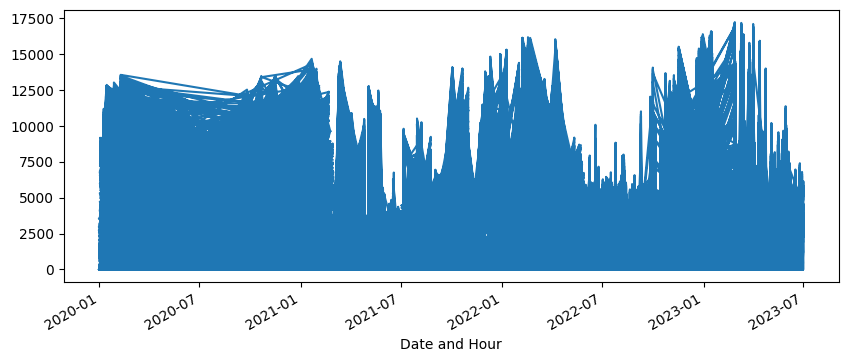

In [64]:
df.Production.plot(figsize=(10,4));

In [38]:
y = df.Production.astype(float).values
y

array([ 244.,  223., 2517., ..., 4589., 4173., 2404.])

In [39]:
y.shape

(59806,)

In [40]:
test_size = int(0.2 * len(y))
train_data = y[:-test_size]
test_data = y[-test_size:]

In [41]:
train_data.shape, test_data.shape

((47845,), (11961,))

In [42]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_data.reshape(-1,1))

In [43]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-0.9706, -0.9731, -0.6962,  ..., -0.8882, -0.0188, -0.8907])

In [44]:
def input_data(sequence,window_size):
    output = []
    L = len(sequence)
    
    for i in range(L-window_size):
        window = sequence[i:i+window_size]
        label = sequence[i+window_size:i+window_size+1]
        output.append((window,label))
    
    return output

In [45]:
train_df = input_data(train_norm,window_size=12)
train_df[:5]

[(tensor([-0.9706, -0.9731, -0.6962, -0.9206, -1.0000, -1.0000, -1.0000, -1.0000,
          -0.6732, -0.5352, -0.6064, -1.0000]),
  tensor([-1.])),
 (tensor([-0.9731, -0.6962, -0.9206, -1.0000, -1.0000, -1.0000, -1.0000, -0.6732,
          -0.5352, -0.6064, -1.0000, -1.0000]),
  tensor([-0.9984])),
 (tensor([-0.6962, -0.9206, -1.0000, -1.0000, -1.0000, -1.0000, -0.6732, -0.5352,
          -0.6064, -1.0000, -1.0000, -0.9984]),
  tensor([-0.9734])),
 (tensor([-0.9206, -1.0000, -1.0000, -1.0000, -1.0000, -0.6732, -0.5352, -0.6064,
          -1.0000, -1.0000, -0.9984, -0.9734]),
  tensor([-0.8904])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.6732, -0.5352, -0.6064, -1.0000,
          -1.0000, -0.9984, -0.9734, -0.8904]),
  tensor([-0.6865]))]

In [46]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=128,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_output, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [47]:
torch.manual_seed(42)
model = LSTM().cuda()
model

LSTM(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [48]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of LSTM model:", total_params)

512
65536
512
512
128
1
Total parameters of LSTM model: 67201


In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [50]:
start_time = time.time()

epochs = 10

losses = []

for i in range(1,epochs+1):
    
    for seq, y_train in train_df:
        seq, y_train = seq.to(device), y_train.to(device)
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.011495986953377724
Epoch 2 -> Loss: 0.004557046107947826
Epoch 3 -> Loss: 0.009475618600845337
Epoch 4 -> Loss: 0.01126500777900219
Epoch 5 -> Loss: 0.0105654401704669
Epoch 6 -> Loss: 0.008720086887478828
Epoch 7 -> Loss: 0.0032181409187614918
Epoch 8 -> Loss: 0.0029106037691235542
Epoch 9 -> Loss: 0.007080924231559038
Epoch 10 -> Loss: 0.006574530154466629
Total time elapsed in LSTM model training: 16.751847871144612 minutes.


In [82]:
forecast = 20
window_size = 12

predictions = train_norm[-window_size:].tolist()

model.eval() # Set model to evaluation phase

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        predictions.append(model(seq).item())

In [83]:
predictions[-20:]

[-0.059827566146850586,
 -0.9510360956192017,
 -0.0672881007194519,
 -0.9710392951965332,
 -0.07506078481674194,
 -0.9722325801849365,
 -0.08166301250457764,
 -0.9608018398284912,
 -0.08677458763122559,
 -0.950860857963562,
 -0.084847092628479,
 -0.9458864331245422,
 -0.08216547966003418,
 -0.9430071711540222,
 -0.08013856410980225,
 -0.9409055709838867,
 -0.07856708765029907,
 -0.9393963813781738,
 -0.07728707790374756,
 -0.9387874603271484]

In [84]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions

array([[1.09459999e+04],
       [1.69499981e+03],
       [1.10209999e+04],
       [1.00011528e+00],
       [1.09960000e+04],
       [1.00011528e+00],
       [1.10569999e+04],
       [1.00011528e+00],
       [1.08689999e+04],
       [9.26000066e+02],
       [8.13000000e+03],
       [9.06000230e+02],
       [7.79026879e+03],
       [4.05714912e+02],
       [7.72845080e+03],
       [2.39968400e+02],
       [7.66404634e+03],
       [2.30080841e+02],
       [7.60934028e+03],
       [3.24795955e+02],
       [7.56698577e+03],
       [4.07166931e+02],
       [7.58295699e+03],
       [4.48385015e+02],
       [7.60517684e+03],
       [4.72242580e+02],
       [7.62197186e+03],
       [4.89656439e+02],
       [7.63499311e+03],
       [5.02161584e+02],
       [7.64559927e+03],
       [5.07207104e+02]])

In [85]:
x = np.arange('2023-05-30T00:00', '2023-06-30T00:00', dtype='datetime64[h]')[-20:]
x

array(['2023-06-29T04', '2023-06-29T05', '2023-06-29T06', '2023-06-29T07',
       '2023-06-29T08', '2023-06-29T09', '2023-06-29T10', '2023-06-29T11',
       '2023-06-29T12', '2023-06-29T13', '2023-06-29T14', '2023-06-29T15',
       '2023-06-29T16', '2023-06-29T17', '2023-06-29T18', '2023-06-29T19',
       '2023-06-29T20', '2023-06-29T21', '2023-06-29T22', '2023-06-29T23'],
      dtype='datetime64[h]')

In [86]:
len(x)

20

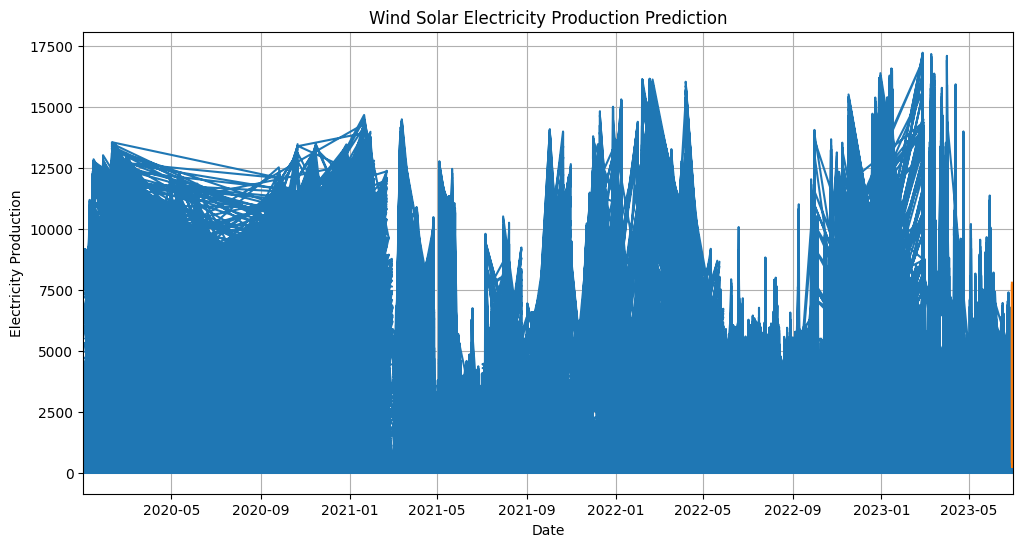

In [87]:
plt.figure(figsize=(12,6))
plt.title('Wind Solar Electricity Production Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.plot(x,true_predictions[-20:])
plt.show();

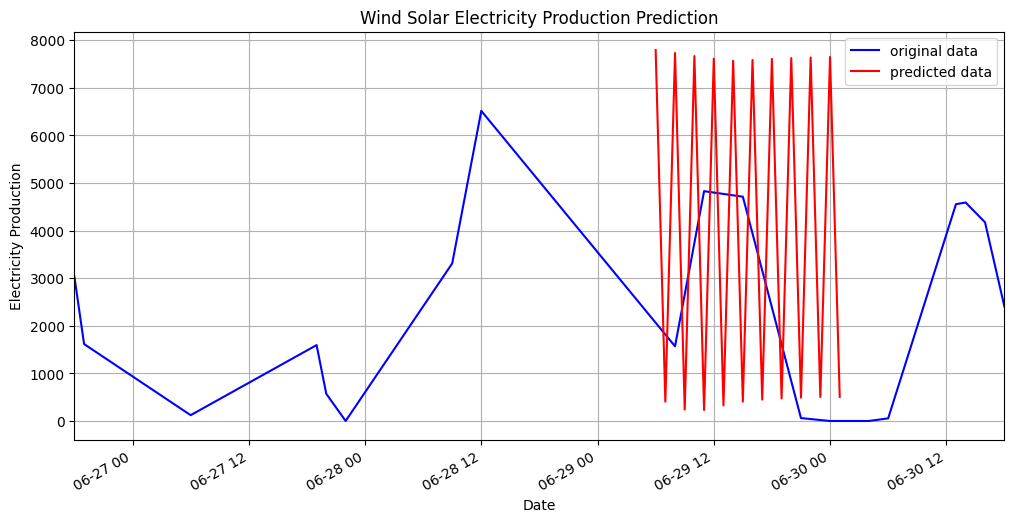

In [88]:
fig = plt.figure(figsize=(12,6))
plt.title('Wind Solar Electricity Production Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['Production'][-20:],'b',label='original data')
plt.plot(x,true_predictions[-20:],'r',label='predicted data')
plt.legend()
plt.show();

In [94]:
start_time = time.time()

y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

model.train()

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        seq, y_train = seq.to(device), y_train.to(device)
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                        torch.zeros(1,1,model.hidden_size,device='cuda'))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 3.4518325264798477e-07
Epoch 2 -> Loss: 0.0001780191232683137
Epoch 3 -> Loss: 5.6733726523816586e-05
Epoch 4 -> Loss: 0.0004842655616812408
Epoch 5 -> Loss: 2.746221525740111e-07
Epoch 6 -> Loss: 3.7819656427018344e-05
Epoch 7 -> Loss: 0.0013338151620700955
Epoch 8 -> Loss: 0.0017598614795133471
Epoch 9 -> Loss: 0.0005270990077406168
Epoch 10 -> Loss: 0.0022403171751648188
Total time elapsed in LSTM model training: 20.757844372590384 minutes.


In [95]:
forecast = 20
window_size = 12
predictions = y_norm[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                       torch.zeros(1,1,model.hidden_size,device='cuda'))
        predictions.append(model(seq).item())

In [96]:
predictions[-20:]

[-0.7991626262664795,
 -0.8000172972679138,
 -0.7764576077461243,
 -0.7508122324943542,
 -0.7516941428184509,
 -0.7472255825996399,
 -0.7382226586341858,
 -0.7665937542915344,
 -0.7679142951965332,
 -0.7632812261581421,
 -0.7592558860778809,
 -0.7609380483627319,
 -0.7595861554145813,
 -0.7538747191429138,
 -0.7503889203071594,
 -0.7503432035446167,
 -0.7480514049530029,
 -0.7448140382766724,
 -0.7463136315345764,
 -0.7489544749259949]

In [97]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions

array([[1568.99975002],
       [4827.00012535],
       [4711.000126  ],
       [  61.00001514],
       [   0.        ],
       [   0.        ],
       [   0.        ],
       [  55.0002408 ],
       [4553.99987251],
       [4589.00009573],
       [4172.99983263],
       [2403.99990678],
       [1729.20978785],
       [1721.85107052],
       [1924.69999731],
       [2145.50667822],
       [2137.91343033],
       [2176.38773382],
       [2253.90290916],
       [2009.62777555],
       [1998.25791836],
       [2038.14864278],
       [2072.80682087],
       [2058.3234036 ],
       [2069.96320188],
       [2119.13866818],
       [2149.15139616],
       [2149.54501748],
       [2169.27740335],
       [2197.15113044],
       [2184.23963249],
       [2161.50197089]])

In [101]:
x = np.arange('2023-06-30T00:00', '2023-07-10T00:00', dtype='datetime64[h]')[:20]
x

array(['2023-06-30T00', '2023-06-30T01', '2023-06-30T02', '2023-06-30T03',
       '2023-06-30T04', '2023-06-30T05', '2023-06-30T06', '2023-06-30T07',
       '2023-06-30T08', '2023-06-30T09', '2023-06-30T10', '2023-06-30T11',
       '2023-06-30T12', '2023-06-30T13', '2023-06-30T14', '2023-06-30T15',
       '2023-06-30T16', '2023-06-30T17', '2023-06-30T18', '2023-06-30T19'],
      dtype='datetime64[h]')

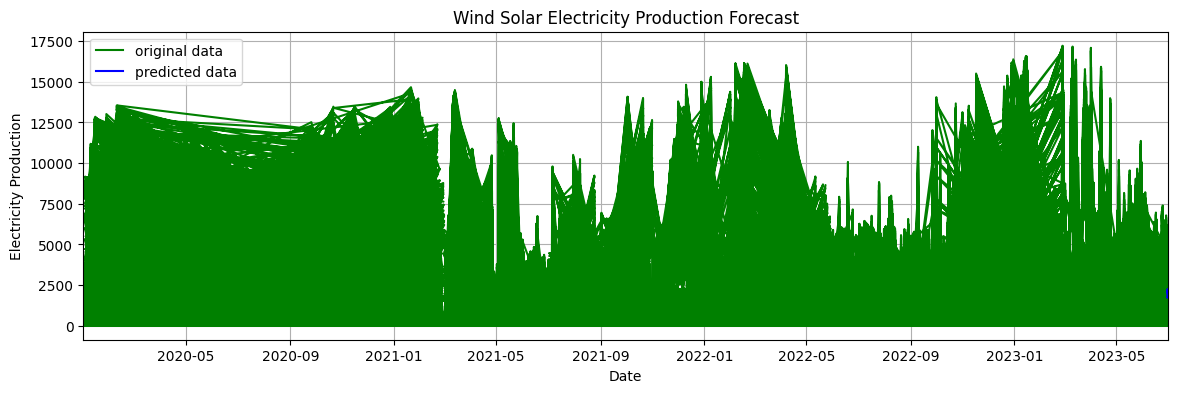

In [106]:
plt.figure(figsize=(14,4))
plt.title('Wind Solar Electricity Production Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'],'g',label='original data')
plt.plot(x,true_predictions[-20:],'b',label='predicted data')
plt.legend()
plt.show();

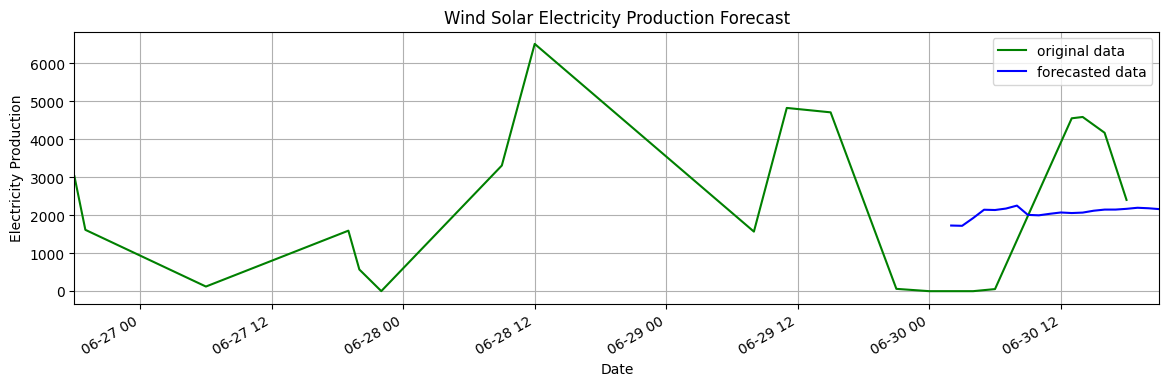

In [107]:
fig = plt.figure(figsize=(14,4))
plt.title('Wind Solar Electricity Production Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['Production'][-20:],'g',label='original data')
plt.plot(x,true_predictions[-20:],'b',label='forecasted data')
plt.legend()
plt.show();

In [108]:
torch.save(model,'wind_solar_electricity_production_forecaster.pt')